### **MARG Machine Listening Tutorial**


# **1. Speech MNIST**


MNIST는 컴퓨터 비전 분야에서 딥러닝 기술을 적용하는 가장 기본적인 예시중 하나입니다.

MNIST 데이터셋에는 손으로 쓴 글씨 이미지가 수만장 포함되어있으며, 이들은 모두 0에서 9 까지의 숫자 중 하나의 class에 해당합니다.

우리 인간은 해당 이미지를 관찰하면 곧바로 해당 이미지가 어떤 숫자인지 클래스를 예측할 수 있지만, 컴퓨터에게 이를 자동으로 예측하도록 맡기는 일은 생각보다 쉽지 않습니다. 같은 숫자 클래스에 해당하는 이미지라 할지라도, 서로 다른 글씨체로 적혀있기 때문에 그들을 일반화하여 구분하는 기준을 만들기가 어렵기 때문입니다.

이러한 문제에 대하여, 심층 신경망이 좋은 해결책이 될 수 있다는 점이 알려짐과 동시에 딥러닝의 황금기를 맞이하게 되었습니다. 딥러닝을 이용하면 직접 규칙을 작성하는 대신, 몇 겹으로 이루어진 간단한 심층 신경망을 설계한 뒤 이를 훈련시킴으로서 99%에 가까운 성능을 얻을 수 있었습니다. 

이러한 간단한 예제에 대한 발견을 시작으로, 딥러닝은 이미지 처리, 자연어 처리, 음성/오디오 신호 처리 분야의 여러 테스크들에서 좋은 성능을 보임이 계속해서 보고되고 있습니다. 그리고 이를 활용한 다양한 응용 어플리케이션 또한 개발되고 있습니다.


---



오늘 tutorial 시간의 첫번째 순서로는, MNIST와 유사한 예시를 오디오 도메인에서 실습해볼 수 있는 speech mnist 데이터를 다루고자 합니다. 인간의 음성으로 zero 부터 nine까지를 발화한 오디오 파일을 듣고, 해당 파일의 클래스를 분류하는 분류기를 직접 설계해볼 것입니다. 분류기 설계를 위한 데이터 전처리, 데이터 로드, 데이터 시각화, 네트워크 설계, 네트워크 훈련, 네트워크 성능 검증의 과정이 포함될 예정입니다. 

###중요!! 실행에 앞서 상단 메뉴의 '런타임' 메뉴를 누르고, '런타임 유형 변경' 한 다음 '하드웨어 가속기'가 'GPU'로 설정되어 있는지 확인해 주세요.






#학습 데이터 준비

먼저, 아래 링크를 누른 뒤 구글 드라이브에 추가해주세요.

# speech mnist - audio
: https://drive.google.com/open?id=15HkFuqPHef2YkITU3JhLtxzxMibF2NuI

# speech mnist - npy
: https://drive.google.com/open?id=1r7hGQNXF6Ccmxrd7snb82b4y1P3wxiEI



# 구글 드라이브 연동
학습 데이터를 가져오기 위해 구글 드라이브와 연동합니다.

링크를 클릭한 후 인증 코드를 복사하여 입력합니다.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


좌측의 파일 탭에서 새로 고침을 누르면 drive 폴더가 연동된 것을 확인할 수 있습니다.

위에서 구글 드라이브에 추가한 학습 데이터를 train 폴더에 압축 해제합니다.

압축 해제하기 위해 학습 데이터의 경로가 필요합니다.

각 파일을 찾아 오른쪽 클릭 후 경로복사를 눌러서 하단의 코드에 순서대로 입력해주세요.

In [2]:
# !mkdir tutorial1
# !unzip -q "여기에 recordings.zip의 경로를 복사해주세요" -d tutorial1
# !unzip -q "여기에 recordings_npy.zip의 경로를 복사해주세요" -d tutorial1
!mkdir -p tutorial1
!unzip -n -q "/content/drive/My Drive/recordings.zip" -d tutorial1
!unzip -n -q "/content/drive/My Drive/recordings_npy.zip" -d tutorial1



# 학습 데이터 둘러보기


압축 해제가 완료되면, 왼쪽 탭에서 우리가 사용할 오디오 데이터를 확인할 수 있습니다.

(Ex. 0_jackson_0.wav)

해당 데이터의 파일 이름은 _ 기호를 바탕으로 세 부분으로 나뉘어집니다.

가장 앞 부분은 해당 오디오 파일이 발화한 영단어 숫자를 의미합니다. 따라서 0_jackson_0.wav는 'zero' 라고 발음한 음성이 담겨있습니다.

중간에 있는 부분은 해당 발화자의 이름을 의미합니다. 

마지막에 있는 부분은 index를 의미합니다.



---


이제, 파일 중 하나를 불러와 살펴보도록 하겠습니다.
우리는 오디오 파일을 다루기 위해, **librosa** 라는 이름의 python library를 사용합니다. 



audio_path 변수에 불러올 파일명을 지정합니다.
오디오를 읽고 확인해볼 수 있습니다.

audio_path에 다른 파일명을 입력하여 다른 음원들도 들어볼 수 있습니다.

(Ex. audio_path = '/1_theo_0.wav')

In [5]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import numpy as np

audio_path = './tutorial1/0_jackson_2.wav' # audio의 경로를 지정
audio, sr = librosa.load(audio_path, sr=None) # audio 불러오기
print('이 오디오의 샘플 레이트는 :', sr, 'Hz')
ipd.Audio(audio, rate=sr, autoplay=False)

이 오디오의 샘플 레이트는 : 8000 Hz


이제 0_jackson_0.wav 파일을 다룰 준비가 되었습니다. 

이제 오디오를 불러왔으니 이를 앞서 튜토리얼에서 했던 것처럼 시각화 시켜보겠습니다.

이번 시각화는 여러분들께서 직접 시도해보세요!

1) waveform plot 하기

2) mel spectrogram 그려보기


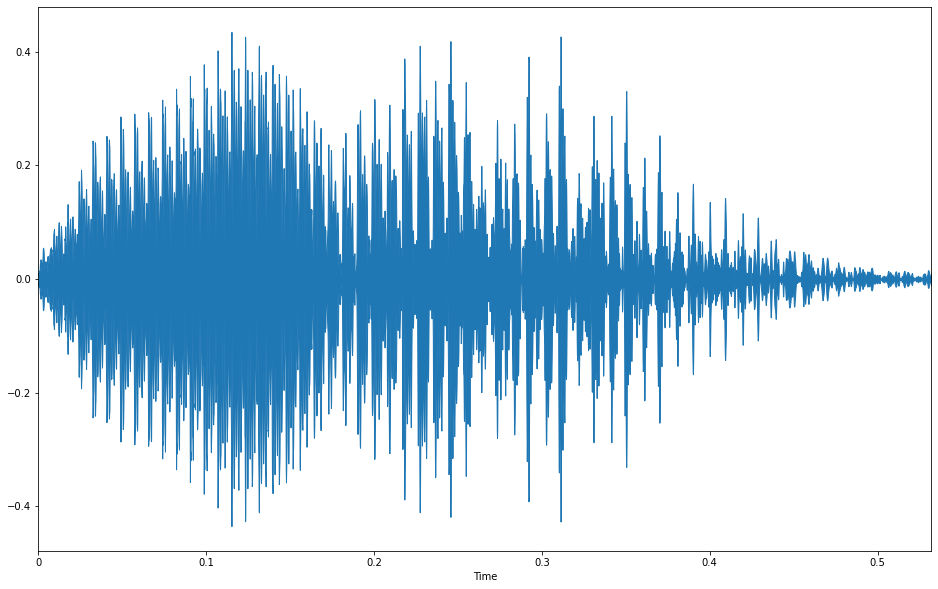

In [6]:
plt.figure(figsize=(16,10)) # 그래프의 사이즈를 지정. (16,10) 정도로 지정해 주겠습니다.
librosa.display.waveplot(audio, sr=sr) # audio와 sample rate을 input값으로 받는 함수. 그래프를 나타내기 위함.
plt.show() # 그래프를 show(보여주는) 함수

다음은 이 오디오의 spectrogram과 mel-spectrogram을 뽑아서 이를 시각화 해보겠습니다.

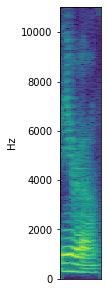

In [7]:
stft = librosa.stft(audio, n_fft=1024, hop_length=256) #librosa를 이용한 stft
spectrogram, phase = librosa.magphase(stft)
#stft를 바탕으로 magnitude spectrogram과 이에 대한 phase(위상)을 얻을 수 있는 함수입니다. 여기서는 magnitude spectrogram만을 사용합니다.

plt.figure(figsize=(0.75,5))
librosa.display.specshow(np.log(spectrogram + 1e-3), cmap='viridis', x_axis=None, y_axis='linear')
# specshow는 spectrogram을 input으로 받아 시각화해주는 함수입니다. cmap 은 colormap의 약자로서, 시각화 해주는 색깔을 설정합니다.
# spectrogram 시각화를 더 분명하게 하기 위해, spectrogram에 1e-3(0.001)을 더하고 로그(np.log) 함수를 취합니다. 
plt.show()

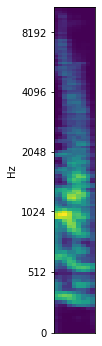

In [8]:
mel = librosa.feature.melspectrogram(audio) # audio에서 mel-spectrogram을 추출합니다
plt.figure(figsize=(0.75,6))
librosa.display.specshow(np.log(mel + 1e-3), cmap='viridis', x_axis=None, y_axis='mel')
plt.show()

다른 숫자를 발음한 멜 스펙트로그램은 어떻게 생겼는지 살펴볼까요?

우선 jackson이 0부터 9까지를 발화한 음원의 멜 스펙트로그램을 한번에 표시해보겠습니다.

각 멜 스펙트로그램의 위에 있는 숫자가 발음한 숫자를 나타냅니다.


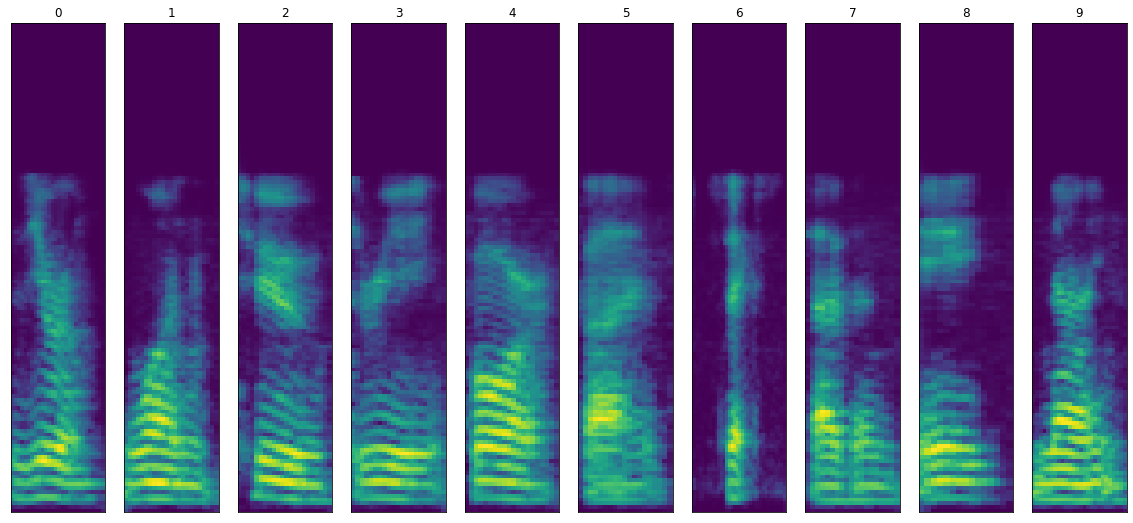

In [9]:
list = []
for i in range(10):
  temp, sr = librosa.load('./tutorial1/' + (str)(i) + '_jackson_0.wav')
  list.append(temp)

plt.figure(figsize=(20,9))
for index, item in enumerate(list):
  mel = librosa.feature.melspectrogram(item)
  plt.subplot(1,10,index+1)
  plt.gca().set_title(index)
  
  plt.yticks([])
  librosa.display.specshow(np.log(mel+1e-3),cmap='viridis', x_axis=None)

앞서 살펴본 멜 스펙트로그램은 jackson이 0부터 9까지 발음한 것입니다.

이번엔 서로 다른 사람이 같은 숫자를 발음했을 때 어떤 차이가 있는지 확인해볼까요?

jackson을 포함한 10명이 0을 발음한 음원을 가져와 이전과 동일하게 멜 스펙트로그램으로 나타내봅시다.

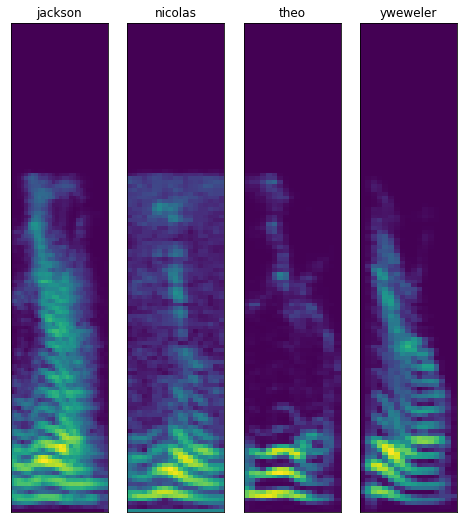

In [10]:
list = []
names = ['jackson','nicolas','theo','yweweler']
for name in names:
  temp, sr = librosa.load('./tutorial1/' + '0_' + name +'_0.wav')
  list.append(temp)

plt.figure(figsize=(8,9))
for index, item in enumerate(list):
  mel = librosa.feature.melspectrogram(item)
  plt.subplot(1,4,index+1)
  plt.gca().set_title(names[index])
  
  plt.yticks([])
  librosa.display.specshow(np.log(mel+1e-3),cmap='viridis', x_axis=None)


# 학습 데이터 전처리

이제 학습을 위해 모든 음원 파일을 불러오도록 하겠습니다. 여기서 저희는 파이썬에서 많이 사용하는 glob라는 툴을 이용해 데이터를 한꺼번에 불러오도록 하겠습니다. glob 라이브러리 안에 있는 glob라는 함수는 지정한 경로와 조건을 만족하는 모든 파일들을 리스트로 저장하도록 하겠습니다.

예를 들어 My Drive 안에 있는 recordings_npy 폴더 속 .npy 로 확장자를 가진 모든 npy 파일들을 불러오고 싶다면 path = glob.glob('./My Drive/recordings_npy/*.npy')와 같은 식으로 실행합니다. 이제 path는 recording_npy 폴더 안에 .npy 확장자를 가진 모든 파일의 리스트를 가지게 되었습니다.

In [11]:
import glob
path = './tutorial1/*.npy' # recording_npy 폴더 안에 .npy 확장자를 가진 파일을 지정합니다
audio_files = glob.glob(path) # 지정한 경로에 있는 파일을 glob.glob()를 이용해 리스트로 리턴합니다.
audio_files = sorted(glob.glob(path)) # 리스트 자료형 안에 있는 파일 이름들을 오름차순으로 정렬해주는 파이썬 함수입니다.
print('자료의 개수는 총 :', len(audio_files), '개') # audio_files 리스트 안에 총 몇 개의 자료가 있는지 확인합니다.

자료의 개수는 총 : 400 개


이제 audio_files라는 리스트가 생성되었고, 그 안에는 모든 음원 파일의 npy 파일 경로가 포함되어 있습니다. 

총 파일 개수는 400개 입니다. 

이제 이 모든 학습 데이터를 불러오고, 각 파일의 정답 label을 만들어보도록 하겠습니다. 


In [12]:
audio_data = []
class_label = []

for item in audio_files:
  audio = np.load(item)
  audio_data.append(audio)
  label = item.split('/')[-1].split('_')[0]
  class_label.append((int)(label))

이제 audio_data에는 음원 데이터가, class_label에는 class 정보가 담겨있습니다. 

각 데이터가 제대로 담겨있는지 확인하기 위해서 개수를 확인해보겠습니다.

다음은 class_label에 담겨져 있는 데이터의 수를 확인하는 코드입니다.

audio_data에도 같은 수의 파일이 있는지 출력해서 확인해보세요


In [13]:
len(class_label)

400

우리가 다루는 sequence 데이터들은 주로 길이가 다릅니다. 하지만 일반적으로 데이터를 딥러닝 학습에 이용하기 위해서는 모두 같은 크기의 데이터가 필요합니다. 따라서 우리는 데이터의 길이를 우리가 가지고 있는 데이터 중 가장 긴 것의 길이로 맞추어야 할 필요가 있습니다. 그것을 우리는 패딩(Padding)이라고 합니다.

In [14]:
# 가장 긴 길이의 오디오를 찾는다.
length = []
for item in audio_data:
	length.append(len(item)) #for문을 돌려서 모든 데이터의 길이를 length라는 리스트 안에 저장합니다

max_length = np.max(length) # length라는 리스트 안에서 가장 긴 오디오의 길이를 리턴합니다
print('가장 긴 오디오의 길이는 :',max_length/8000,'seconds')

가장 긴 오디오의 길이는 : 2.386 seconds


최대 길이를 알게되었으니 이제 음원을 받아서 최대 길이만큼 padding해주는 함수를 작성합니다.

In [15]:
# 임의의 오디오를 특정 길이가 되도록 padding 하는 함수
def pad_audio(audio):
	length = len(audio)
	return np.concatenate((audio, np.zeros((max_length-length))))

이제, pad_audio 함수를 바탕으로 audio_data에 들어있는 음원 데이터에 padding을 합니다.

그리고 멜 스펙트로그램으로 변환하여 X_all에 저장합니다.

In [16]:
# 이제, 모든 오디오를 패딩한 다음, mel spectrogram 을 뽑아서 X_all에 저장한다.
X_all = []
for item in audio_data:
	padded_audio = pad_audio(item)
	mel = librosa.feature.melspectrogram(padded_audio, n_fft=1024, hop_length=256)
	log_mel = np.log(mel+1e-3)
	X_all.append(np.expand_dims((log_mel), axis=-1))

이제 X_all에 저장되어 있는 학습 데이터가 어떻게 생겼는지 확인해보겠습니다.

무작위로 이 안에 있는 다섯 개의 스펙트로그램만 뽑아 확인해 볼까요?


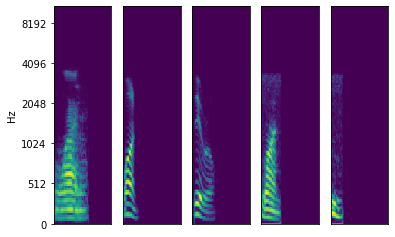

In [17]:
for i in range(5):
  plt.subplot(1,5,i+1)
  if i == 0:
    librosa.display.specshow(X_all[np.random.choice(100)][:,:,0], cmap='viridis', x_axis=None, y_axis='mel')
  else:
    librosa.display.specshow(X_all[np.random.choice(100)][:,:,0], cmap='viridis', x_axis=None, y_axis=None)

우리가 데이터를 가장 긴 오디오에 맞춰서 패딩했기 때문에 이제 뒷부분에 약간의 공백이 생긴 것을 확인할 수 있습니다.

이제, 모든 오디오의 정답지를 y_all에 저장합니다. 

이 때 one-hot encoding을 사용합니다.

one-hot encoding이란 정답지를 벡터로 변환하는 작업을 뜻합니다.

Ex)

정답지: 0 --> [1,0,0,0,0,0,0,0,0,0]

정답지: 1 --> [0,1,0,0,0,0,0,0,0,0]

정답지: 2 --> [0,0,1,0,0,0,0,0,0,0]

In [18]:
# 마찬가지로, 모든 오디오의 정답지를 y_all에 저장한다. 이 때 one-hot encoding을 사용한다.
y_all = []
for item in class_label:
	y_all.append(np.eye(10)[item])

이제, 전체 데이터, X_all과 정답지 y_all이 만들어졌습니다.

학습이 잘 이루어졌는지 확인하기 위한 용도로 이들을 train set과 test set으로 분리합니다.

전체에서 10%를 test set으로 지정합니다.

In [19]:
# 전체 X_all, y_all이 만들어졌다. 
# 이제 이들을 train set과 test set으로 분리한다. 비율은 9:1.

X_all = np.asarray(X_all)
y_all = np.asarray(y_all)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.1, random_state=123, stratify=y_all)


#모델 설계

학습 데이터는 모두 준비되었고, 이제 학습을 위한 모델을 설계해보겠습니다.

In [20]:
# 이제 학습 데이터 준비까지 끝났다. 학습을 위해, 모델을 설계해보자. 

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, pooling
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32,3,3,activation='relu', input_shape=(128, 75, 1)))
model.add(Conv2D(32,3,3,activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

이제 모델의 구조 설계는 끝났습니다.

2개의 Convolutional layer와 max pooling, dropout과 Fully-connected layer로 구성된 아주 간단한 모델을 구성해 보았습니다.

이제 이 모델에 어떠한 loss를 줄 것이고, 어떤 optimizer를 이용해 학습 시킬지 정해보겠습니다



In [21]:
# 전체 모델은 sequential 하게 conv layer 및 pooling layer, 그리고 dense로 구성되어있다. 
# 이제 해당 모델에 어떤 loss를 줄거고, 어떤 optimizer를 쓸지 정해주자. 
opt = Adam(lr=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

학습을 시작하기 전에 설계한 모델의 정보를 출력해봅니다.

각 층마다 출력 모양, 파라미터 수를 확인할 수 있습니다.

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 25, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 8, 32)         9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               114816    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

#모델 훈련

이제, 학습을 시작합니다.

Epoch은 전체 데이터에 대한 반복 학습 횟수입니다.

학습 도중 각 단계마다 오차(loss)와 정확도(acc)가 출력됩니다.

학습이 진행되는 동안 이 둘이 어떻게 변하는지 확인합니다.

In [23]:
# 모델과 loss, optimizer가 모두 정해졌으니, 이제 학습을 시켜보자.
hist = model.fit(X_train, y_train, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
12/12 [==============================] - 0s 5ms/step - loss: 2.4635 - accuracy: 0.0972
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 2.2825 - accuracy: 0.1278
Epoch 3/200
12/12 [==============================] - 0s 3ms/step - loss: 2.2649 - accuracy: 0.1389
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 2.1891 - accuracy: 0.2000
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 2.1062 - accuracy: 0.2722
Epoch 6/200
12/12 [==============================] - 0s 3ms/step - loss: 1.9811 - accuracy: 0.2694
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 1.7990 - accuracy: 0.3889
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 1.6789 - accuracy: 0.4500
Epoch 9/200
12/12 [==============================] - 0s 3ms/step - loss: 1.5954 - accuracy: 0.4222
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 1.4388 - accuracy: 0.4639
Epoch 11/

# 모델 평가 및 결과 분석

이제 학습이 완료되었습니다.

미리 나눠둔 test set을 이용해 실제 성능을 확인해봅니다.

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", score[1])

Test Accuracy: 0.9750000238418579


테스트 결과를 바탕으로 confusion matrix를 그려봅니다.

Confusion matrix는 실제 정답과 예측한 정답 사이의 관계를 나타낸 표입니다.


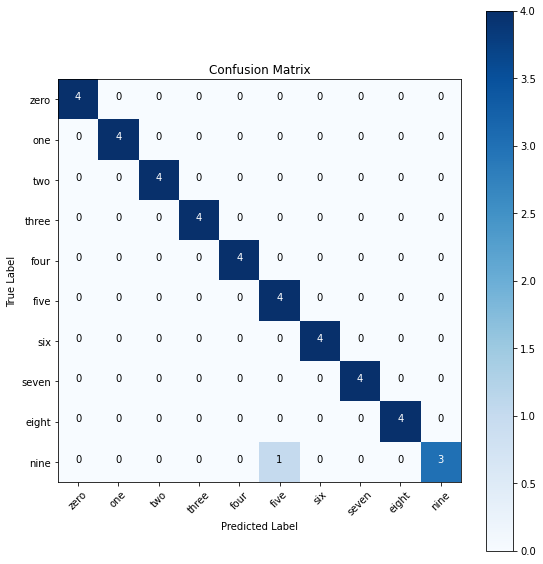

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_gt = np.argmax(y_test, axis=1)

plt.figure(figsize=(8,8))
cm = confusion_matrix(y_gt, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'], rotation=45)
plt.yticks(tick_marks, ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
thresh = cm.max()/2.
normalize = False
fmt = '.2f' if normalize else 'd'
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j,i, format(cm[i,j], fmt), horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()


다음은 우리의 모델이 입력 데이터를 어떤 식으로 맵핑하는지를 확인하기 위한 방법을 다룹니다.

같은 class의 데이터에 대해 서로 유사한 값을 갖는지 확인하기 위해 입력 데이터에 대해 중간 layer에서  처리한 feature를 가져옵니다. 

In [26]:
model_embedding = Model(inputs=[model.input], outputs=[model.layers[-3].output])
temp = model_embedding.predict(X_train)

이제 우리는 훈련 데이터에 대해 모델이 128차원으로 축소한 feature를 얻었습니다.

이를 시각화하기 위해 T-SNE를 적용합니다. T-SNE는 고차원 공간상에서의 거리를  낮은 차원에서도 가깝게 유지하도록하는 차원 축소 방법입니다.

따라서 앞서 얻어진 128차원의 벡터들을 2차원 평면으로 축소시켜 시각화에 용이하도록 바꿔줍니다.

In [27]:
from sklearn.manifold import TSNE
X = temp

X_embedded = TSNE(n_components=2,random_state=100).fit_transform(X)

2차원으로 축소한 데이터를 각 class에 따라 색을 다르게 표현하여 그래프에 표시합니다.

이를 통해 같은 class끼리 잘 뭉쳐있는지 확인을 할 수 있습니다.

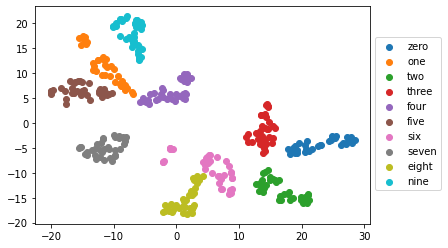

In [28]:
# 그리고 나서, 각 벡터들을 2차원 평면상에 클래스에 따라 그려보면 다음과 같다. 

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

plt.clf()
y_gt = np.argmax(y_train,axis=1)
for i in range(10):
	index = np.where(y_gt==i)[0]
	plt.scatter(X_embedded[index][:,0], X_embedded[index][:,1], c = colors[i], label=numbers[i])


plt.legend(bbox_to_anchor=(1,0.88))
plt.show()

다음은 훈련 중 loss와 accuracy가 어떻게 변했는지를 그래프로 나타내보겠습니다.

학습 과정이 길다면 한 눈에 살펴볼 수 있는 좋은 방법입니다.

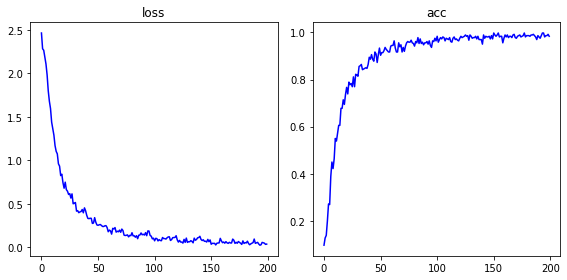

In [29]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'b-', label="t")

plt.title("loss")

plt.subplot(1, 2, 2)
plt.title("acc")

plt.plot(hist.history['accuracy'], 'b-', label="t")

plt.tight_layout()
plt.show()